# Noise2Void Experiment

[CVPR 2019 : Noise2Void - Learning Denoising from Single Noisy Image](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf)

Key idea: 
- Blind-spot network(BSN), network learn the mapping between mask pixel(s) and every other pixels
- the expect of output identical to clean image when noise mean is zero and i.i.d and there traing data inf.

Pros: 
1. single noisy image denoising, has tremendous practicality on medical denoising task
2. can adaptive to any noise distribution since its learn denoising directly from noisy image 

Cons:
1. by masking certain pixel(s), the quality of denoising decrease, especially for high-frequency content
2. strong assumption of zero mean noise and pixels i.i.d, leading to poor performance when it dealing with structured noise 
3. denoising performance slightly degrade to N2N but still better than BM3D

In [1]:
import os
import copy
import json
import time

import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image, timer_decorator
from module.datasets import load_4d_dicom, save_4d_dicom, restore_data

from module.models import UNet2_5D
from module.datasets import MaskDataset


import h5py
from tqdm.notebook import tqdm


import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


## Load preprocessed data

Noisy data...float32 (shape:(11, 24, 71, 192, 192); range:[0.0,1.0]; mean:0.5030226111412048); std:0.02147510275244713
{'original_min': -32768.0, 'original_max': 32767.0, 'z_score_mean': 201.4710693359375, 'z_score_std_dev': 1407.2664794921875, 'noise_min': -23.428024291992188, 'noise_max': 23.14098358154297}


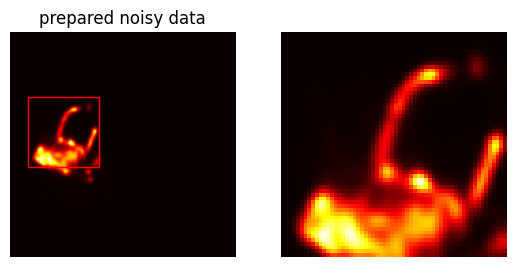

In [2]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_real_0.00_batch.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = json.loads(f['restore_info'][()])
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)

display_image_in_detail(noisy_data[0, 11, 38], title="prepared noisy data")

## Process Denoising

## 1. import denoising network

In [3]:
model = UNet2_5D(in_channels=3, out_channels=1)
model = model.to(device)
print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))

summary(model, [(1, 192, 192), (1, 192, 192), (1, 192, 192)])

The number of parameters of the network is:  138372097
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           1,792
       BatchNorm2d-2         [-1, 64, 192, 192]             128
              ReLU-3         [-1, 64, 192, 192]               0
            Conv2d-4         [-1, 64, 192, 192]          36,928
       BatchNorm2d-5         [-1, 64, 192, 192]             128
            Conv2d-6         [-1, 64, 192, 192]             256
              ReLU-7         [-1, 64, 192, 192]               0
         UNetBlock-8         [-1, 64, 192, 192]               0
         MaxPool2d-9           [-1, 64, 96, 96]               0
           Conv2d-10          [-1, 128, 96, 96]          73,856
      BatchNorm2d-11          [-1, 128, 96, 96]             256
             ReLU-12          [-1, 128, 96, 96]               0
           Conv2d-13          [-1, 128, 96, 96] 

## 2. create mask dataset and dataloader

In [4]:
def split_tensor(data_tensor):
    """split tensor into train, test, vali tensor

    Args:
        data_tensor (_type_): _description_

    Returns:
        _type_: _description_
    """
    test_tensor = data_tensor[0:1]
    
    rest_tensor = data_tensor[1:]

    total_samples = rest_tensor.shape[0]
    
    train_ration = 0.8
    train_length = int(train_ration * total_samples)
    val_length = total_samples - train_length
    
    train_tensor, val_tensor = random_split(rest_tensor, [train_length, val_length])

    return train_tensor.dataset, val_tensor.dataset, test_tensor


# convert to ndarray to tensor
noisy_tensor = torch.tensor(noisy_data[:, :, np.newaxis, :, :, :], dtype=torch.float32) 
#noisy_tensor = noisy_tensor.to(device)
print(f"noisy_tensor\n shape: {noisy_tensor.shape}; range:({torch.min(noisy_tensor)},{torch.max(noisy_tensor)}) ;mean:{torch.mean(noisy_tensor)}; std:{torch.std(noisy_tensor)} ") # (batch, time, channel, depth, height, width


# create dataset

train_tensor, val_tensor, test_tensor = split_tensor(noisy_tensor) # split input tensor 

num_masks = 1

train_dataset = MaskDataset(train_tensor, num_masks)
val_dataset = MaskDataset(val_tensor, num_masks)
test_dataset = MaskDataset(test_tensor, num_masks)

print(f"train_dataset: {len(train_dataset)}")
print(f"val_dataset: {len(val_dataset)}")
print(f"test_dataset: {len(test_dataset)}")

# create dataloader
batch_size = 32
num_workers = 12

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

noisy_tensor
 shape: torch.Size([11, 24, 1, 71, 192, 192]); range:(0.0,1.0) ;mean:0.5030819773674011; std:0.021474946290254593 


top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(1.0,0.026108214631676674); mean:0.502531886100769; std:0.01883421652019024
mask_middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(1.0,0.010589798912405968); mean:0.5023232698440552; std:0.017967814579606056
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(1.0,0.0753643587231636); mean:0.5024494528770447; std:0.01814495027065277
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(1.0,0.010589798912405968); mean:0.5023182034492493; std:0.017898691818118095


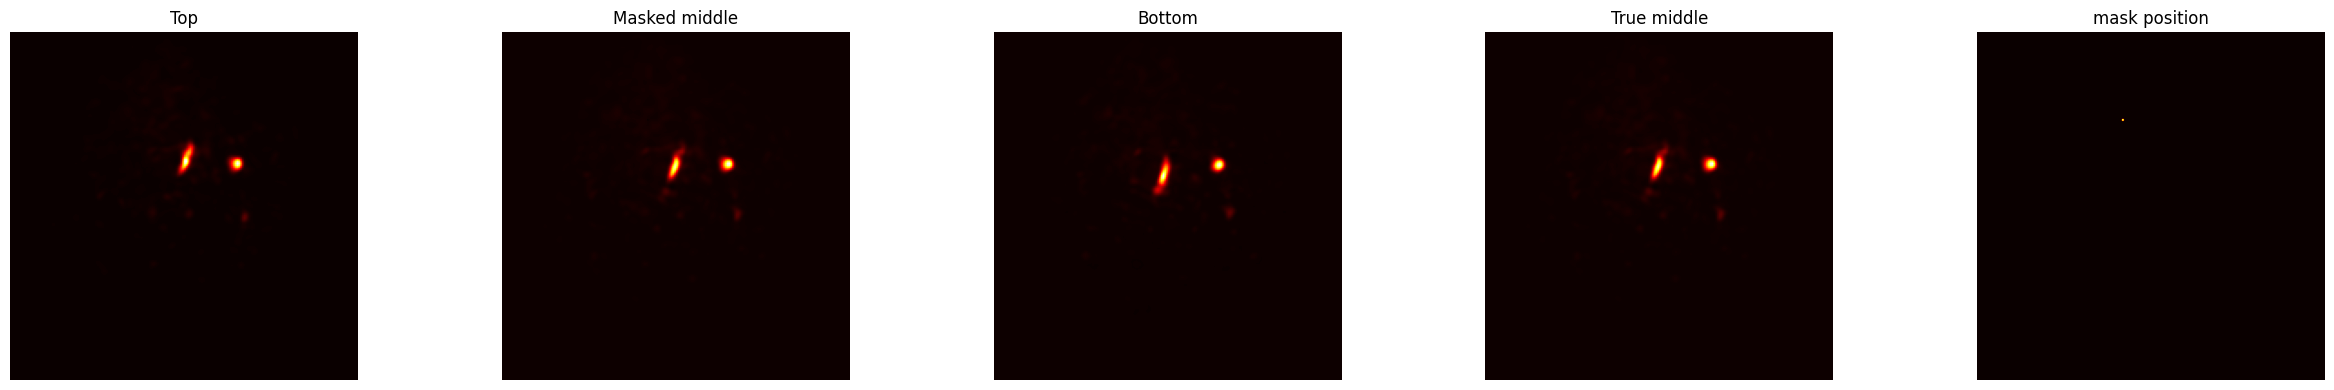

In [6]:
# example dataloader feed
top_slice, mask_middle_slice, bottom_slice, middle_slice = next(iter(train_loader))

print(f"top_slice: {top_slice.dtype} {top_slice.shape} range:({torch.max(top_slice)},{torch.min(top_slice)}); mean:{torch.mean(top_slice)}; std:{torch.std(top_slice)}")
print(f"mask_middle_slice: {mask_middle_slice.dtype} {mask_middle_slice.shape} range:({torch.max(mask_middle_slice)},{torch.min(mask_middle_slice)}); mean:{torch.mean(mask_middle_slice)}; std:{torch.std(mask_middle_slice)}")
print(f"bottom_slice: {bottom_slice.dtype} {bottom_slice.shape} range:({torch.max(bottom_slice)},{torch.min(bottom_slice)}); mean:{torch.mean(bottom_slice)}; std:{torch.std(bottom_slice)}")
print(f"middle_slice: {middle_slice.dtype} {middle_slice.shape} range:({torch.max(middle_slice)},{torch.min(middle_slice)}); mean:{torch.mean(middle_slice)}; std:{torch.std(middle_slice)}")

# select the show baych index
idx = 1

fig, axes = plt.subplots(1, 5, figsize=(25, 4))

axes[0].imshow(top_slice[idx].squeeze().numpy(), cmap='hot')
axes[0].set_title('Top')

axes[1].imshow(mask_middle_slice[idx].squeeze().numpy(), cmap='hot')
axes[1].set_title('Masked middle')

axes[2].imshow(bottom_slice[idx].squeeze().numpy(), cmap='hot')
axes[2].set_title('Bottom')

axes[3].imshow(middle_slice[idx].squeeze().numpy(), cmap='hot')
axes[3].set_title('True middle')

#
difference = (mask_middle_slice[idx] != middle_slice[idx]).float().squeeze().cpu().numpy()
axes[4].imshow(difference, cmap='hot')
axes[4].set_title('mask position')
    
for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

## 3.  define training modules 

In [45]:
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc="Training", dynamic_ncols=True)
    for top_slice, mask_middle_slice, bottom_slice, middle_slice in pbar:
        top_slice, mask_middle_slice, bottom_slice, middle_slice = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slice.to(device)
        
        # Forward
        outputs = model(top_slice, mask_middle_slice, bottom_slice)
        
        # Zero the gradient buffers
        optimizer.zero_grad()
        
        loss = criterion(outputs, middle_slice)
        
        # Backward
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({"batch_loss": loss.item()})
    
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    return avg_loss



def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0 
    pbar = tqdm(val_loader, desc="Validating", dynamic_ncols=True)
    with torch.no_grad():
        for top_slice, mask_middle_slice, bottom_slice, middle_slice in pbar:
            top_slice, mask_middle_slice, bottom_slice, middle_slice = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slice.to(device)
            outputs = model(top_slice, mask_middle_slice, bottom_slice)
            loss = criterion(outputs, middle_slice)
            total_loss += loss.item()
            pbar.set_postfix({"batch_loss": loss.item()})
    
    avg_loss = total_loss / len(val_loader)
    
    return avg_loss

# @timer_decorator
# def test(model, test_loader, device):
#     model.eval()
#     preds = []
#     targets = []
#     pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
#     with torch.no_grad():
#         for top_slice, mask_middle_slice, bottom_slice, middle_slice in pbar:
#             top_slice, mask_middle_slice, bottom_slice, middle_slice = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slice.to(device)
            
#             pred = model(top_slice, mask_middle_slice, bottom_slice)
#             preds.append(pred.cpu()) # predict
#             targets.append(middle_slice.cpu()) # original input data
            
#     return preds, targets
# def test(model, test_loader, device, original_shape):
#     # 初始化两个全0的tensor用于存放预测和目标
#     preds = torch.zeros(original_shape).to(device)
#     targets = torch.zeros(original_shape).to(device)

#     model.eval()
#     pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
#     with torch.no_grad():
#         for idx, (top_slice, mask_middle_slice, bottom_slice, middle_slices) in enumerate(pbar):
#             top_slice, mask_middle_slice, bottom_slice, middle_slices = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slices.to(device)
            
#             batch_preds = model(top_slice, mask_middle_slice, bottom_slice)
            
#             for b_idx, pred in enumerate(batch_preds):
#                 # 计算应该放置预测值和目标值的位置
#                 patience_idx = (idx * len(batch_preds) + b_idx) // (original_shape[1] * (original_shape[3] - 2))
#                 time_idx = ((idx * len(batch_preds) + b_idx) % (original_shape[1] * (original_shape[3] - 2))) // (original_shape[3] - 2)
#                 depth_idx = (idx * len(batch_preds) + b_idx) % (original_shape[3] - 2) + 1
                
#                 pred = pred.squeeze(0)
#                 middle_slice = middle_slices[b_idx].squeeze(0)
                
#                 preds[patience_idx, time_idx, :, depth_idx, :, :] = pred
#                 targets[patience_idx, time_idx, :, depth_idx, :, :] = middle_slice

#     return preds.cpu(), targets.cpu()
@timer_decorator
def test(model, test_loader, device, dataset):
    model.eval()
    p, t, d = dataset.p, dataset.t, dataset.d
    # Note: d represents number of continuous slices after subtracting 2
    original_shape = (p, t, dataset.data_tensor.shape[2], d+2, dataset.data_tensor.shape[4], dataset.data_tensor.shape[5])

    preds = torch.zeros(original_shape).to(device)
    targets = torch.zeros(original_shape).to(device)

    pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
    with torch.no_grad():
        for idx, (top_slice, mask_middle_slice, bottom_slice, middle_slice) in enumerate(pbar):
            top_slice, mask_middle_slice, bottom_slice, middle_slice = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slice.to(device)
            
            batch_preds = model(top_slice, mask_middle_slice, bottom_slice)

            for b_idx, pred in enumerate(batch_preds):
                pred = pred.squeeze(0) # [channels, height, width]
                true_idx = idx*test_loader.batch_size + b_idx
                patience_idx = true_idx // (t * d)
                time_idx = (true_idx % (t * d)) // d
                depth_idx = true_idx % d + 1

                preds[patience_idx, time_idx, :, depth_idx, :, :] = pred
                targets[patience_idx, time_idx, :, depth_idx, :, :] = middle_slice[b_idx]

    return preds.cpu(), targets.cpu()




@timer_decorator
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, patience=5, save_path='path/to/your/directory'):
    best_loss = float('inf')
    early_stopping_counter = 0
    best_epoch = -1
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)
        val_loss = validate(model, val_loader, criterion, device)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, LR: {current_lr:.4e}")

        # Save the model with the best validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1  # 1-based counting for epoch
            best_save_path = os.path.join(save_path, f'best_model_epoch_{best_epoch}.pth')
            torch.save(best_model_wts, best_save_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping after {patience} epochs without improvement.")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [8]:
# define loss, optimizer, lr_scheduler
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


## 4. process training

In [11]:
trained_model = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=200, patience=10, save_path="./check_points")

Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 1/200, Train Loss: 0.0995, Validation Loss: 0.0897


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 2/200, Train Loss: 0.0783, Validation Loss: 0.0658


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 3/200, Train Loss: 0.0511, Validation Loss: 0.0351


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 4/200, Train Loss: 0.0175, Validation Loss: 0.0036


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 5/200, Train Loss: 0.0036, Validation Loss: 0.0036


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 6/200, Train Loss: 0.0036, Validation Loss: 0.0036


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 7/200, Train Loss: 0.0036, Validation Loss: 0.0036


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 8/200, Train Loss: 0.0036, Validation Loss: 0.0036


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 9/200, Train Loss: 0.0036, Validation Loss: 0.0036


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 10/200, Train Loss: 0.0036, Validation Loss: 0.0036


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 11/200, Train Loss: 0.0036, Validation Loss: 0.0036


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 12/200, Train Loss: 0.0036, Validation Loss: 0.0036


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 13/200, Train Loss: 0.0036, Validation Loss: 0.0036


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 14/200, Train Loss: 0.0036, Validation Loss: 0.0036


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 15/200, Train Loss: 0.0036, Validation Loss: 0.0036


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 16/200, Train Loss: 0.0036, Validation Loss: 0.0036


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 17/200, Train Loss: 0.0036, Validation Loss: 0.0037


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 18/200, Train Loss: 0.0036, Validation Loss: 0.0036


Training:   0%|          | 0/518 [00:00<?, ?it/s]

Validating:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch 19/200, Train Loss: 0.0036, Validation Loss: 0.0036
Early stopping after 10 epochs without improvement.
train_and_evaluate running: 4851.613206740469 second


## 5. process denoising

In [14]:
# load best model
model.load_state_dict(torch.load('check_points/best_model_epoch_9.pth'))


<All keys matched successfully>

In [46]:
# denoising 
preds, targets = test(model, test_loader, device, test_dataset)

Testing:   0%|          | 0/52 [00:00<?, ?it/s]

test running: 11.629909314215183 second


denoised data: float32; shape:(24, 71, 192, 192); range:(0.0,0.5000101327896118); mean:0.4859163165092468; std:0.08272815495729446
true_data data: float32; shape:(24, 71, 192, 192); range:(0.0,1.0); mean:0.48897048830986023; std:0.08597568422555923


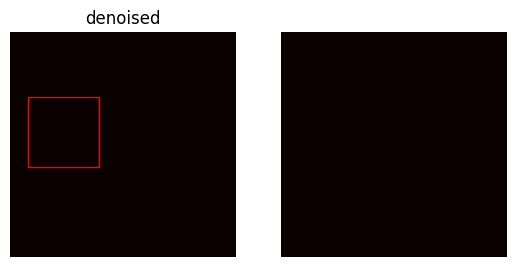

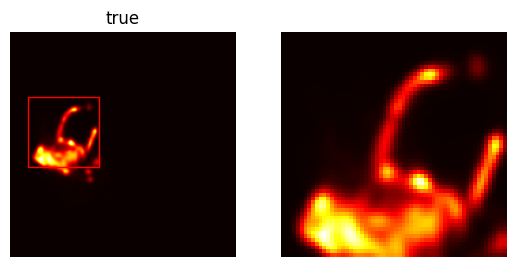

In [59]:
denoised_data = preds[0].squeeze(1).numpy()
true_data = targets[0].squeeze(1).numpy()

print(f"denoised data: {denoised_data.dtype}; shape:{denoised_data.shape}; range:({np.min(denoised_data)},{np.max(denoised_data)}); mean:{np.mean(denoised_data)}; std:{np.std(denoised_data)}")
print(f"true_data data: {true_data.dtype}; shape:{true_data.shape}; range:({np.min(true_data)},{np.max(true_data)}); mean:{np.mean(true_data)}; std:{np.std(true_data)}")


display_image_in_detail(denoised_data[11, 25], title='denoised')
display_image_in_detail(true_data[11, 38], title='true')

## 6. metrics evaluation

# Save denormalized denoised data into 16-bit DICOM files

In [ ]:
# denormalized denoised data
restored_data = restore_data(denoised_data, restore_info)
print(f"restore_data: {restored_data.dtype} shape:{restored_data.shape}; range:({np.min(restored_data)},{np.max(restored_data)}); mean:{np.mean(restored_data)}; std:{np.std(restored_data)}")
display_4d_image(restored_data)

In [ ]:
# save denormalized denoised data as 16-bit gray-scale .DICOM files
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/BM4D/PT_20p 150_120 OSEM_real_0.00_batch'

save_4d_dicom(origin_dicom_folder, restored_data, output_folder)